In [1]:
%cd ..

/mnt/cup/labs/hasson/zaid/fmri-convs


In [2]:
from glob import glob

import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nilearn import datasets, image
from neuromaps.datasets import fetch_mni152
from util.atlas import get_schaefer

from util.path import Path
from constants import CONVS_STRANGERS, CONVS_FRIENDS, CONVS

In [3]:
def reduce_consecutive(df: pd.DataFrame, on: str) -> pd.DataFrame:
    newdf = df.copy()
    newdf['key'] = (df[on] != df[on].shift(1)).astype(int).cumsum()
    newdf = newdf.groupby('key').first()  # NOTE hardcoded function
    newdf.reset_index(drop=True, inplace=True)
    return newdf

# Timing files
validate timing files after `copy_timings.py`

In [4]:
timepath = Path(root="stimuli", datatype="timing", suffix="events", ext=".csv")
files = glob(timepath.starstr(["conv", "datatype"]))
len(files)

295

In [5]:
# create one df of all timing files
dfs = []
for filename in files:
    df = pd.read_csv(filename)
    filepath = Path.frompath(filename)
    df.insert(0, "conv", filepath["conv"])
    dfs.append(df)
df = pd.concat(dfs)
df.sort_values(["conv", "run", "trial"], inplace=True)
df.reset_index(drop=True, inplace=True)
timingdf = df

print(len(df))
df.head()

8921


,conv,run,trial,item,condition,role,time.time,run.time,comm.time,audio_position
0,103,1,1.0,1.0,R,trial_intro,1.579303e+09,12.071489,NaN,0
1,103,1,1.0,1.0,R,listener,1.579303e+09,21.085684,0.013840,0
2,103,1,1.0,1.0,R,speaker,1.579303e+09,32.169620,11.097776,352256
3,103,1,1.0,1.0,R,listener,1.579303e+09,173.450472,152.378629,4861952
4,103,1,1.0,1.0,R,trial_end,1.579303e+09,201.116802,180.044958,5746688


In [6]:
# any missing conversations?
set(CONVS) - set(df.conv.unique().tolist())

set()

In [8]:
# any conversations missing runs?
dfc = df[["conv", "run"]].drop_duplicates().reset_index(drop=True)
dft = dfc.groupby("conv").run.count()
dft[dft.values != 5]

Series([], Name: run, dtype: int64)

In [10]:
# any conversations missing transcripts?
dfc = df[["conv", "run", "trial"]].drop_duplicates().reset_index(drop=True)
dft = dfc.groupby("conv").trial.count()
dft[dft.values != 20]

Series([], Name: trial, dtype: int64)

# Utterance transcripts
validate transcripts after `copy_transcripts.py`

Errors for num_speakers != 2
```
[x] conv_114_run_5_set_3_trial_17_item_17_condition_G_first_B
[x] conv_128_run_1_set_1_trial_1_item_2_condition_G_first_A

[#] conv_146_run_5_set_3_trial_19_item_20_condition_G_first_A
[#] conv_147_run_1_set_1_trial_2_item_1_condition_G_first_A

[-] conv_103_run_2_set_1_trial_2_item_5.0_condition_G_first_B
[!] conv_103_run_3_set_1_trial_7_item_12.0_condition_G_first_B
[*] conv_105_run_1_set_1_trial_1_item_1_condition_G_first_B
[*] conv_106_run_3_set_2_trial_10_item_10_condition_G_first_A
[*] conv_113_run_2_set_1_trial_8_item_7_condition_G_first_B
[*] conv_127_run_2_set_1_trial_4_item_7_condition_G_first_A
[*] conv_128_run_2_set_1_trial_5_item_6_condition_G_first_A
[*] conv_128_run_5_set_3_trial_17_item_17_condition_G_first_B
[*] conv_130_run_3_set_2_trial_9_item_9_condition_G_first_A
[*] conv_130_run_4_set_2_trial_14_item_14_condition_G_first_B
[*] conv_134_run_1_set_1_trial_2_item_1_condition_G_first_A
[*] conv_143_run_4_set_3_trial_8_item_15_condition_G_first_B
[*] conv_147_run_5_set_3_trial_20_item_19_condition_G_first_B
[*] conv_148_run_1_set_1_trial_2_item_2_condition_G_first_A
[*] conv_148_run_2_set_1_trial_6_item_5_condition_G_first_A
[*] conv_153_run_5_set_3_trial_18_item_17_condition_G_first_A
[*] conv_172_run_3_set_2_trial_10_item_10_condition_G_first_A
[*] conv_172_run_5_set_3_trial_20_item_20_condition_G_first_A
[*] conv_173_run_2_set_1_trial_8_item_7_condition_G_first_B

x = one subject spoke the entire prompt
* = fixed in `fix_transcripts.sh`
! = fixed but timings look wrong
# = good as-is (self-correct)
- = replaced file with new version
```

In [11]:
transpath = Path(root="stimuli", datatype="transcript", suffix="utterance", ext=".csv")
files = glob(transpath.starstr(["conv", "datatype"]))
len(files)

590

In [12]:
dfs = []
for filename in files:
    df = pd.read_csv(filename)
    filepath = Path.frompath(filename)
    df.insert(0, "trial", filepath["trial"])
    df.insert(0, "run", filepath["run"])
    df.insert(0, "conv", filepath["conv"])
    dfs.append(df)
df = pd.concat(dfs)
df.sort_values(["conv", "run", "trial", "onset"], inplace=True)
df.reset_index(drop=True, inplace=True)

print(len(df))
df.head()

4389


,conv,run,trial,speaker,onset,text
0,103,1,2,103,42,"Um, uh I'd want to be famous for something, I ..."
1,103,1,2,103,43,"But honestly, I, like if you make a big discov..."
2,103,1,2,3,44,"Um I think I want to be famous also, probably ..."
3,103,1,2,3,46,Especially because then everything that you do...
4,103,1,2,103,71,"Yeah, definitely."


In [13]:
# what conversations are missing?
set(CONVS) - set(df.conv.unique().tolist())

set()

In [14]:
# which conversations are missing transcripts?
dfc = df[["conv", "run", "trial"]].drop_duplicates().reset_index(drop=True)
dft = dfc.groupby("conv").trial.count()
dft[dft.values != 10]

Series([], Name: trial, dtype: int64)

In [15]:
# any utterances with non-increasing onsets?
df.groupby(['conv', 'run', 'trial']).onset.filter(lambda x: not x.is_monotonic_increasing)

Series([], Name: onset, dtype: int64)

In [16]:
# which convs have only one speaker?
# these are expected:
# conv_114_run_5_set_3_trial_17_item_17_condition_G_first_B
# conv_128_run_1_set_1_trial_1_item_2_condition_G_first_A

ids = df.groupby(['conv', 'run', 'trial']).speaker.filter(lambda x: (x == x.iloc[0]).all())
df.iloc[ids.index][['conv', 'run', 'trial', 'speaker']].drop_duplicates()

,conv,run,trial,speaker
768,114,5,17,114
1368,128,1,1,28


## Do they match with TimingLogs?
ignore this for now. we will assume transcripts are correct because they're based on timing logs

In [5]:
transdf = df.copy()
transdf.drop("text", axis=1, inplace=True)
transdf["trial4"] = 1 + (transdf.trial - 1) % 4
transdf

,conv,run,trial,speaker,onset,trial4
0,103,1,2,103,42,2
1,103,1,2,103,43,2
2,103,1,2,3,44,2
3,103,1,2,3,46,2
4,103,1,2,103,71,2
...,...,...,...,...,...,...
4384,175,5,20,75,74,4
4385,175,5,20,175,106,4
4386,175,5,20,75,123,4
4387,175,5,20,175,154,4


In [10]:
timingdf = timingdf[timingdf.role.isin(['speaker', 'listener'])]

In [22]:
records = []
for idx, group in transdf.groupby(['conv', 'run', 'trial4']):
    conv, run, trial = idx

    subdf = transdf[(transdf.conv == conv) & (transdf.run == run) & (transdf.trial4 == trial)]
    newdf = reduce_consecutive(subdf, 'speaker')

    records.append((conv, run, trial, len(group), len(newdf)))

In [26]:
matchdf = pd.DataFrame(records, columns=('conv', 'run', 'trial', 'trans_size', 'time_size'))
matchdf['matching'] = matchdf.trans_size == matchdf.time_size
matchdf

,conv,run,trial,trans_size,time_size,matching
0,103,1,2,11,6,False
1,103,1,4,6,6,True
2,103,2,2,14,13,False
3,103,2,4,10,7,False
4,103,3,2,7,6,False
...,...,...,...,...,...,...
585,175,3,4,9,8,False
586,175,4,2,14,13,False
587,175,4,3,12,12,True
588,175,5,2,12,12,True


In [30]:
conv = 103
run = 1
trial = 4

In [31]:
subdf = timingdf[(timingdf.conv == conv) & (timingdf.run == run) & (timingdf.trial == trial)].copy()
subdf['run.time'] -= subdf.iloc[0]['run.time']
subdf

,conv,run,trial,item,condition,role,time.time,run.time,comm.time,audio_position
21,103,1,4.0,4.0,G,listener,1.579304e+09,0.000000,0.000020,17203200
22,103,1,4.0,4.0,G,speaker,1.579304e+09,50.591321,50.718468,18829312
23,103,1,4.0,4.0,G,listener,1.579304e+09,93.299838,93.299857,20180992
24,103,1,4.0,4.0,G,speaker,1.579304e+09,119.805892,119.933040,21037056
25,103,1,4.0,4.0,G,listener,1.579304e+09,136.715433,136.715452,21557248
26,103,1,4.0,4.0,G,speaker,1.579304e+09,167.255569,167.382717,22544384


In [32]:
subdf = transdf[(transdf.conv == conv) & (transdf.run == run) & (transdf.trial4 == trial)]
reduce_consecutive(subdf, 'speaker')

,conv,run,trial,speaker,onset,trial4
0,103,1,4,3,0,4
1,103,1,4,103,18,4
2,103,1,4,3,101,4
3,103,1,4,103,122,4
4,103,1,4,3,140,4
5,103,1,4,103,170,4


# Word-level transcripts

check out the processed transcripts

In [11]:
# new whisperx
transpath = Path(root="stimuli", datatype="transcript", suffix="aligned", ext=".csv")
files = glob(transpath.starstr(["conv", "datatype"]))
len(files)

579

In [4]:
transpath = Path(root="stimuli", datatype="transcript", suffix="word", ext=".csv")
files = glob(transpath.starstr(["conv", "datatype"]))
len(files)

590

In [12]:
dfs = []
for filename in files:
    df = pd.read_csv(filename)
    filepath = Path.frompath(filename)
    df.insert(0, "item", filepath["item"])
    df.insert(0, "set", filepath["set"])
    df.insert(0, "trial", filepath["trial"])
    df.insert(0, "run", filepath["run"])
    df.insert(0, "conv", filepath["conv"])
    dfs.append(df)
df = pd.concat(dfs)
df.sort_values(["conv", "run", "trial", "start"], inplace=True)
df.reset_index(drop=True, inplace=True)

print(len(df))
df.head()

282017


,conv,run,trial,set,item,speaker,sentence,word,start,end,score
0,103,1,4,1,4,3,1,"Um,",0.02,0.060,0.000
1,103,1,4,1,4,3,1,I,0.08,0.100,0.001
2,103,1,4,1,4,3,1,think,0.12,0.240,0.100
3,103,1,4,1,4,3,1,the,0.26,0.360,0.332
4,103,1,4,1,4,3,1,perfect,0.38,0.821,0.390


In [13]:
# what conversations are missing?
set(CONVS) - set(df.conv.unique().tolist())

set()

In [14]:
# Which trials are missing?
dfc = df[["conv", "run", "trial"]].drop_duplicates().reset_index(drop=True)
dft = dfc.groupby("conv").trial.count()
dft[dft.values != 10]

conv
103    7
109    9
150    9
155    9
165    9
166    7
172    9
Name: trial, dtype: int64

In [10]:
df.token[df.token.str.startswith('[')].value_counts()

AttributeError: 'DataFrame' object has no attribute 'token'

In [9]:
df[~df.is_punct]

,conv,run,trial,turn,utterance,speaker,onset,offset,sentence_id,is_punct,token,token_norm
0,103,1,2,0,0,103,42,43,0,False,Um,um
2,103,1,2,0,0,103,42,43,0,False,uh,uh
3,103,1,2,0,0,103,42,43,0,False,I'd,i'd
4,103,1,2,0,0,103,42,43,0,False,want,want
5,103,1,2,0,0,103,42,43,0,False,to,to
...,...,...,...,...,...,...,...,...,...,...,...,...
347995,175,5,20,6,6,75,174,180,1,False,though,though
347997,175,5,20,6,6,75,174,180,1,False,if,if
347998,175,5,20,6,6,75,174,180,1,False,I,i
347999,175,5,20,6,6,75,174,180,1,False,said,said


In [10]:
df[df.token.str.startswith('(')]

,conv,run,trial,turn,utterance,speaker,onset,offset,sentence_id,is_punct,token,token_norm
147206,132,4,15,3,3,132,69,180,2,True,(,NaN
305690,166,3,10,19,19,166,106,109,0,True,(,NaN
305694,166,3,10,20,20,66,109,111,0,True,(,NaN
305885,166,3,10,31,31,166,162,169,1,True,(,NaN
305889,166,3,10,32,32,66,169,173,0,True,(,NaN
305958,166,3,12,5,5,166,18,24,1,True,(,NaN
306439,166,3,12,40,40,66,173,180,0,True,(,NaN
327688,172,3,10,9,9,172,120,129,0,True,(,NaN
331665,173,2,5,2,2,173,75,101,2,True,(,NaN


In [17]:
# df_sents = df.groupby(['conv', 'run', 'trial', 'speaker', 'utterance', 'sentence_id'], sort=False).token.apply(lambda x: ''.join(x))
df_sents = df.groupby(
    ["conv", "run", "trial", "speaker", "utterance", "sentence_id"], sort=False
).agg({"onset": "first", "offset": "last", "set": "first", "item": "first", "token": lambda x: "".join(x)})
df_sents.to_csv("sentences.csv")

In [18]:
df_sents

onset  offset  set  item   
conv run trial speaker utterance sentence_id                             
103  1   2     103     0         0               42      43    1     2  \
                       1         0               43      44    1     2   
                                 1               43      44    1     2   
                                 2               43      44    1     2   
               3       2         0               44      46    1     2   
...                                             ...     ...  ...   ...   
175  5   20    75      4         6              123     154    3    20   
               175     5         0              154     174    3    20   
                                 1              154     174    3    20   
               75      6         0              174     180    3    20   
                                 1              174     180    3    20   

                                                                                          token  
conv run trial speaker utterance sentence_id                                                     
103  1   2     103     0         0            Um, uh I'd want to be famous for something, I ...  
                       1         0            But honestly, I, like if you make a big discov...  
                                 1                        I don't know, that'd be pretty cool.   
                                 2                                         Sure, I could do it.  
               3       2         0            Um I think I want to be famous also, probably ...  
...                                                                                         ...  
175  5   20    75      4         6                                          Like, I don't know.  
               175     5         0                            Yeah, I don't think that's okay.   
                                 1            I mean, I think, I don't know, maybe if I was ...  
               75      6         0                                                       Yeah.   
                                 1            I, I just don't know if she'd really listen an...  

[19095 rows x 5 columns]

## Aligned transcripts
first, check that MFA created TextGrids

In [36]:
transpath = Path(root="stimuli", datatype="aligned", ext=".TextGrid")
files = glob(transpath.starstr(["conv", "datatype"]))
len(files)

309

In [37]:
records = []
for file in files:
    path = Path.frompath(file)
    records.append([path["conv"], path["run"], path["trial"]])
df = pd.DataFrame(records, columns=["conv", "run", "trial"])
df.sort_values(["conv", "run", "trial"], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,conv,run,trial
0,101,1,1
1,101,1,3
2,101,2,6
3,101,2,8
4,101,3,10
...,...,...,...
304,174,3,12
305,174,4,13
306,174,4,15
307,174,5,18


In [38]:
# what conversations are missing?
set(CONVS_STRANGERS) - set(df.conv.unique().tolist())

{119}

In [39]:
# Which trials are missing?
dft = df.groupby("conv").trial.count()
dft[dft.values != 10]

conv
143    11
171     8
Name: trial, dtype: int64

# Merged transcripts

In [51]:
transpath = Path(root="stimuli", datatype="aligned", ext=".csv")
files = glob(transpath.starstr(["conv", "datatype"]))
len(files)

332

In [54]:
dfs = []
for filename in files:
    if "analysis" in filename:
        continue
    df = pd.read_csv(filename, index_col=0)
    filepath = Path.frompath(filename)
    df.insert(0, "conv", filepath["conv"])
    dfs.append(df)
df = pd.concat(dfs)
df.sort_values(["conv", "run", "trial", "onset"], inplace=True)
df.reset_index(drop=True, inplace=True)

print(len(df))
df.head()

147285


,conv,run,trial,turn,utterance,speaker,sentence_id,token,token_norm,onset,offset
0,101,1,1,0,0,1,0.0,Hi,hi,4.00,4.34
1,101,1,1,0,0,1,1.0,Um,um,4.34,4.59
2,101,1,1,0,0,1,1.0,so,so,4.72,5.18
3,101,1,1,0,0,1,1.0,given,given,5.36,5.69
4,101,1,1,0,0,1,1.0,the,the,5.69,7.92


In [56]:
# what conversations are missing?
set(CONVS_STRANGERS) - set(df.conv.unique().tolist())

{119, 171}

In [57]:
# Which trials are missing?
dfc = df[["conv", "run", "trial"]].drop_duplicates().reset_index(drop=True)
dft = dfc.groupby("conv").trial.count()
dft[dft.values != 10]

conv
143    11
Name: trial, dtype: int64

In [61]:
dft

conv
101    10
104    10
105    10
106    10
107    10
108    10
111    10
112    10
114    10
116    10
117    10
120    10
122    10
123    10
126    10
128    10
129    10
131    10
132    10
133    10
137    10
138    10
142    10
143    11
153    10
156    10
157    10
158    10
163    10
174    10
Name: trial, dtype: int64

In [62]:
# Number of words per trial
df.groupby(["conv", "run", "trial"]).token.count().describe()

count    301.000000
mean     489.318937
std       59.304451
min      123.000000
25%      458.000000
50%      492.000000
75%      525.000000
max      665.000000
Name: token, dtype: float64

In [7]:
# Number of words per trial per speaker (how short turns are between speakers)
df.groupby(["conv", "run", "trial", "speaker"]).token.count().describe()

count    382.000000
mean     244.298429
std       62.107222
min       58.000000
25%      205.000000
50%      244.500000
75%      280.000000
max      469.000000
Name: token, dtype: float64

In [64]:
# Number of words per conversations
df.conv.value_counts(sort=False)

conv
101    4958
104    4848
105    5021
106    4734
107    5456
108    5181
111    4702
112    5036
114    5235
116    4204
117    5847
120    4907
122    4760
123    4457
126    5865
128    4477
129    5087
131    4570
132    4287
133    3985
137    5157
138    5565
142    4868
143    4501
153    5092
156    5121
157    5002
158    4591
163    4786
174    4985
Name: count, dtype: int64

In [63]:
# Runs per conversation
# Should be 5 runs per conversation
df[["conv", "run"]].drop_duplicates().reset_index(drop=True).groupby("conv").run.count()

conv
101    5
104    5
105    5
106    5
107    5
108    5
111    5
112    5
114    5
116    5
117    5
120    5
122    5
123    5
126    5
128    5
129    5
131    5
132    5
133    5
137    5
138    5
142    5
143    5
153    5
156    5
157    5
158    5
163    5
174    5
Name: run, dtype: int64

# Brain confounds

In [31]:
CONFOUNDS = set(
    [
        "a_comp_cor_00",
        "a_comp_cor_01",
        "a_comp_cor_02",
        "a_comp_cor_03",
        "a_comp_cor_04",
        "trans_x",
        "trans_y",
        "trans_z",
        "rot_x",
        "rot_y",
        "rot_z",
        "cosine00",
    ]
)

In [19]:
path = Path(
    root="data/derivatives/fmriprep",
    datatype="func",
    sub="*",
    ses="1",
    desc="confounds",
    suffix="timeseries",
    ext=".tsv",
)
path

data/derivatives/fmriprep/sub-*/ses-1/func/sub-*_ses-1_desc-confounds_timeseries.tsv

In [22]:
files = glob(path.starstr(["sub", "ses", "datatype"]))
len(files)

739

In [33]:
badfiles = []
for filepath in files:
    df = pd.read_csv(filepath, sep="\t", nrows=0)
    if len(CONFOUNDS.intersection(set(df.columns.tolist()))) < len(CONFOUNDS):
        print(filepath)
        badfiles.append(filepath)
print(len(badfiles))

data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-1_desc-confounds_timeseries.tsv
1


In [34]:
df = pd.read_csv(
    "data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-1_desc-confounds_timeseries.tsv",
    sep="\t",
)
df

,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,...,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26
0,618.441162,NaN,382469.471237,NaN,426.450592,NaN,181860.107275,NaN,520.307416,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,617.029841,-1.411321,380725.824613,1.991828,422.433100,-4.017492,178449.723778,16.140243,519.439973,-0.867443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,616.414654,-0.615187,379967.025821,0.378455,422.615533,0.182433,178603.888907,0.033282,519.557217,0.117244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,614.814679,-1.599975,377997.089620,2.559920,421.459828,-1.155705,177628.386916,1.335654,518.813584,-0.743632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,615.233214,0.418535,378511.907310,0.175171,419.217436,-2.242393,175743.258343,5.028325,518.718417,-0.095167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,607.126079,1.027816,368602.075615,1.056407,418.517448,-0.579977,175156.854325,0.336373,516.491259,-0.837065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,609.078719,1.952640,370976.885342,3.812802,420.560703,2.043255,176871.304556,4.174889,517.687123,1.195864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
63,608.902201,-0.176517,370761.890736,0.031158,413.767731,-6.792971,171203.735356,46.144461,517.119241,-0.567882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,607.437951,-1.464250,368980.864067,2.144030,412.636644,-1.131087,170268.999840,1.279359,517.380701,0.261460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
[c for c in df.columns.tolist() if "cosine" in c]

[]

In [58]:
!ls -lhtr data/sub-101/ses-1/func/*task-Conv*gz

-r--r--r--. 1 ltsoi g_tamir  16M Sep 11  2022 data/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-01_bold.nii.gz
-r--r--r--. 1 ltsoi g_tamir 128M Sep 11  2022 data/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-02_bold.nii.gz
-r--r--r--. 1 ltsoi g_tamir 127M Sep 11  2022 data/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-03_bold.nii.gz
-r--r--r--. 1 ltsoi g_tamir 127M Sep 11  2022 data/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-04_bold.nii.gz
-r--r--r--. 1 ltsoi g_tamir 127M Sep 11  2022 data/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-05_bold.nii.gz


In [96]:
sub = 109
for run in range(1, 6):
    img = nib.load(
        f"data/sub-{sub:03d}/ses-1/func/sub-{sub:03d}_ses-1_task-Conv_run-{run:02d}_bold.nii.gz"
    )
    print(sub, run, img.shape)
    del img

109 1 (74, 74, 46, 544)
109 2 (74, 74, 46, 544)
109 3 (74, 74, 46, 544)
109 4 (74, 74, 46, 544)
109 5 (74, 74, 46, 544)


In [52]:
!ls -lhtr data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz

-rw-rw-r--. 1 ltsoi games 216M May 16  2022 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
-rw-rw-r--. 1 ltsoi games 215M May 16  2022 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
-rw-rw-r--. 1 ltsoi games 215M May 16  2022 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
-rw-rw-r--. 1 ltsoi games 216M May 16  2022 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
-rw-rw-r--. 1 ltsoi games  26M May 16  2022 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


# Atlases

In [58]:
sub, run = 150, 5
img = nib.load(
    f"data/derivatives/fmriprep/sub-{sub:03d}/ses-1/func/sub-{sub:03d}_ses-1_task-Conv_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
)
img.shape, img.affine

((65, 77, 65, 544),
 array([[   3. ,    0. ,    0. ,  -96.5],
        [   0. ,    3. ,    0. , -132.5],
        [   0. ,    0. ,    3. ,  -78.5],
        [   0. ,    0. ,    0. ,    1. ]]))

In [32]:
mni_atlases = fetch_mni152(density="3mm")
mni_atlas = nib.load(mni_atlases["2009cAsym_brainmask"])
mni_atlas.shape

(65, 77, 65)

In [7]:
mni_atlases

{'2009cAsym_T1w': PosixPath('/usr/people/zzada/neuromaps-data/atlases/MNI152/tpl-MNI152NLin2009cAsym_res-3mm_T1w.nii.gz'),
 '2009cAsym_T2w': PosixPath('/usr/people/zzada/neuromaps-data/atlases/MNI152/tpl-MNI152NLin2009cAsym_res-3mm_T2w.nii.gz'),
 '2009cAsym_PD': PosixPath('/usr/people/zzada/neuromaps-data/atlases/MNI152/tpl-MNI152NLin2009cAsym_res-3mm_PD.nii.gz'),
 '2009cAsym_brainmask': PosixPath('/usr/people/zzada/neuromaps-data/atlases/MNI152/tpl-MNI152NLin2009cAsym_res-3mm_desc-brain_mask.nii.gz'),
 '2009cAsym_CSF': PosixPath('/usr/people/zzada/neuromaps-data/atlases/MNI152/tpl-MNI152NLin2009cAsym_res-3mm_label-csf_probseg.nii.gz'),
 '2009cAsym_GM': PosixPath('/usr/people/zzada/neuromaps-data/atlases/MNI152/tpl-MNI152NLin2009cAsym_res-3mm_label-gm_probseg.nii.gz'),
 '2009cAsym_WM': PosixPath('/usr/people/zzada/neuromaps-data/atlases/MNI152/tpl-MNI152NLin2009cAsym_res-3mm_label-wm_probseg.nii.gz')}

In [54]:
print(
    np.unique(our_bm.get_fdata(), return_counts=True)
)  # (array([0., 1.]), array([246755,  78570]))
print(np.unique(mni_atlas.get_fdata(), return_counts=True))

(array([0., 1.]), array([242071,  83254]))
(array([0.        , 1.00000006]), array([255445,  69880]))


In [52]:
our_bm.affine

array([[   3. ,    0. ,    0. ,  -96.5],
       [   0. ,    3. ,    0. , -132.5],
       [   0. ,    0. ,    3. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [51]:
mni_atlas.affine

array([[   3.,    0.,    0.,  -96.],
       [   0.,    3.,    0., -132.],
       [   0.,    0.,    3.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [28]:
mnimask = datasets.load_mni152_brain_mask(3)
mnimask.shape

(67, 79, 64)

In [5]:
import pandas as pd

In [29]:
mnimask.affine

array([[   3.,    0.,    0.,  -98.],
       [   0.,    3.,    0., -134.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [58]:
our_bold.affine

array([[   3. ,    0. ,    0. ,  -96.5],
       [   0. ,    3. ,    0. , -132.5],
       [   0. ,    0. ,    3. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [6]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1)
atlasimg = nib.load(atlas["maps"])
atlasimg.shape

(182, 218, 182)

In [7]:
records = []
for item in atlas["labels"]:
    records.append(item.decode().split("_")[1:])
df = pd.DataFrame(records, columns=["hemi", "network", "area", "n"])

In [8]:
df.network.value_counts()

network
Default        24
Vis            17
DorsAttn       15
SomMot         14
Cont           13
SalVentAttn    12
Limbic          5
Name: count, dtype: int64

In [10]:
df.area.value_counts()

area
Post          11
PFC            7
PFCl           6
Par            6
Temp           5
Med            5
pCunPCC        4
2              4
1              4
6              4
3              4
4              4
5              4
7              3
TempPole       3
PFCdPFCm       3
8              3
FrOperIns      3
OFC            2
PrCv           2
pCun           2
Cing           2
FEF            2
TempOccPar     2
PFCv           2
ParOper        1
PFCmp          1
9              1
Name: count, dtype: int64

In [9]:
df.groupby(["network", "area"]).count()

hemi   n
network     area                
Cont        Cing           2   2
            PFCl           5   5
            PFCmp          1   1
            Par            3   3
            pCun           2   2
Default     PFC            7   7
            PFCdPFCm       3   3
            PFCv           2   2
            Par            3   3
            Temp           5   5
            pCunPCC        4   4
DorsAttn    FEF            2   2
            Post          11  11
            PrCv           2   2
Limbic      OFC            2   2
            TempPole       3   3
SalVentAttn FrOperIns      3   3
            Med            5   5
            PFCl           1   1
            ParOper        1   1
            TempOccPar     2   2
SomMot      1              2   0
            2              2   0
            3              2   0
            4              2   0
            5              2   0
            6              2   0
            7              1   0
            8              1   0
Vis         1              2   0
            2              2   0
            3              2   0
            4              2   0
            5              2   0
            6              2   0
            7              2   0
            8              2   0
            9              1   0

## Language ROIs

In [8]:
from nilearn.image import resample_to_img

In [247]:
from neuromaps.datasets import fetch_fslr
from neuromaps.transforms import mni152_to_fslr
from surfplot import Plot
from surfplot.utils import threshold

surfaces = fetch_fslr(data_dir="mats")
lh, rh = surfaces["inflated"]


def plot_surface_brain(
    data: np.ndarray,
    title: str = "",
    cmap: str = "YlOrRd_r",
    val_threshold=None,
    vmin: float = None,
    vmax: float = None,
):
    stat_lh, stat_rh = mni152_to_fslr(data)  # type: ignore
    if val_threshold:
        stat_lh = threshold(stat_lh.agg_data(), val_threshold)
        stat_rh = threshold(stat_rh.agg_data(), val_threshold)

    p = Plot(surf_lh=lh, surf_rh=rh)  # , views='lateral', size=(400, 200), zoom=1.2)
    # sulc_lh, sulc_rh = surfaces["sulc"]
    # p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)

    crange = None
    if vmax is not None:
        crange = (-vmax, vmax)
        if vmin is not None:
            crange = (vmin, vmax)

    p.add_layer(
        {"left": stat_lh, "right": stat_rh}, cmap=cmap, cbar=False, color_range=crange
    )
    # p.add_layer({'left': stat_lh, 'right': stat_rh}, cmap='gray', cbar=False, as_outline=True)

    fig = p.build()
    fig.suptitle(title)
    return fig

In [300]:
# Load fedorenko atlas
ev_atlas = nib.load("mats/allParcels_language_SN220.nii")
ev_labels = [
    "LH_IFGorb",
    "LH_IFG",
    "LH_MFG",
    "LH_AntTemp",
    "LH_MidTemp",
    "LH_PostTemp",
    "RH_IFGorb",
    "RH_IFG",
    "RH_MFG",
    "RH_AntTemp",
    "RH_MidTemp",
    "RH_PostTemp",
]
ev_atlas.shape, ev_labels

((91, 109, 91),
 ['LH_IFGorb',
  'LH_IFG',
  'LH_MFG',
  'LH_AntTemp',
  'LH_MidTemp',
  'LH_PostTemp',
  'RH_IFGorb',
  'RH_IFG',
  'RH_MFG',
  'RH_AntTemp',
  'RH_MidTemp',
  'RH_PostTemp'])

In [288]:
# Resample to our space
brain_mask = (
    "data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-"
    "Conv_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
)
ev_img = resample_to_img(ev_atlas, brain_mask, interpolation="nearest")

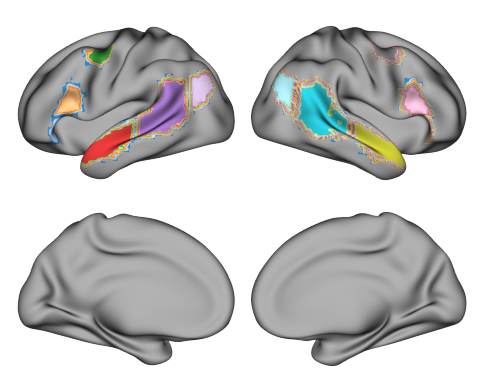

In [263]:
fig = plot_surface_brain(ev_img, cmap="tab20", val_threshold=0)
fig.show()

In [289]:
# Load schaefer atlas
sch_atlas, sch_labels = get_schaefer()
sch_img = nib.load(sch_atlas)
sch_img

In [290]:
records = []
for item in sch_labels:
    records.append(item.split("_")[1:])
df = pd.DataFrame(records, columns=["hemi", "network", "area", "n"])
df

,hemi,network,area,n
0,LH,VisCent,Striate,1
1,LH,VisCent,Striate,2
2,LH,VisCent,Striate,3
3,LH,VisCent,Striate,4
4,LH,VisCent,ExStr,1
...,...,...,...,...
995,RH,TempPar,18,None
996,RH,TempPar,19,None
997,RH,TempPar,20,None
998,RH,TempPar,21,None


In [291]:
add_rois = {
    "SM_cent": ("SomMotB", "Cent"),
    "SM_s2": ("SomMotB", "S2"),
    "SM_aud": ("SomMotB", "Aud"),
    "vmPFC": ("DefaultA", "PFCm", slice(1, None)),
    "PMC": ("DefaultA", "pCunPCC"),
}

In [292]:
sch_data = sch_img.get_fdata().astype(np.int32)
sch_data.shape

(65, 77, 65)

In [293]:
lang_data = ev_img.get_fdata().astype(np.int32)
lang_data.shape

(65, 77, 65)

In [303]:
lang_labels = ev_labels.copy()
lang_labels

['LH_IFGorb',
 'LH_IFG',
 'LH_MFG',
 'LH_AntTemp',
 'LH_MidTemp',
 'LH_PostTemp',
 'RH_IFGorb',
 'RH_IFG',
 'RH_MFG',
 'RH_AntTemp',
 'RH_MidTemp',
 'RH_PostTemp']

In [304]:
start_k = len(ev_labels) + 1

for hemi in ["LH", "RH"]:
    for roiname, parts in add_rois.items():
        subdf = df[(df.hemi == hemi) & (df.network == parts[0]) & (df.area == parts[1])]
        if len(parts) > 2:
            subdf = subdf.iloc[parts[2]]
        start_id, stop_id = subdf.index[0], subdf.index[-1]
        print(hemi, roiname, start_id, stop_id)

        lang_data[np.isin(sch_data, np.arange(start_id, stop_id + 1))] = start_k
        lang_labels.append(f"{hemi}_{roiname}")
        start_k += 1

LH SM_cent 108 118
LH SM_s2 119 131
LH SM_aud 133 146
LH vmPFC 411 421
LH PMC 388 409
RH SM_cent 616 627
RH SM_s2 628 642
RH SM_aud 644 657
RH vmPFC 938 946
RH PMC 925 936


In [298]:
lang_img = nib.Nifti1Image(lang_data, ev_img.affine, ev_img.header)
nib.save(lang_img, "mats/language_rois.nii.gz")

In [302]:
pd.DataFrame(lang_labels).to_csv("mats/language_rois.csv", header=None)

this is for testing

In [209]:
subdf = df[(df.hemi == "LH") & (df.network == "DefaultA") & (df.area == "PFCm")]
start_id, stop_id = subdf.index[0], subdf.index[-1]
print(start_id, stop_id)
subdf

410 421


,hemi,network,area,n
410,LH,DefaultA,PFCm,1
411,LH,DefaultA,PFCm,2
412,LH,DefaultA,PFCm,3
413,LH,DefaultA,PFCm,4
414,LH,DefaultA,PFCm,5
415,LH,DefaultA,PFCm,6
416,LH,DefaultA,PFCm,7
417,LH,DefaultA,PFCm,8
418,LH,DefaultA,PFCm,9
419,LH,DefaultA,PFCm,10


In [207]:
# regions = np.arange(start_id, stop_id+1)
regions = np.arange(388, 410)
array_data = sch_img.get_fdata()
array_data = np.where(np.isin(array_data, regions), array_data, 0)
array_img = nib.Nifti1Image(array_data.astype(np.int8), resampled.affine)
print(array_data.sum())

176943.0


In [250]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap("orange", "regions", N=1)

In [ ]:
for i, roiname in enumerate(labels, 1):
    region_data = array_data.astype(np.int8)
    region_data[array_data != i] = 0
    region_img = nib.Nifti1Image(region_data, resampled.affine)
    fig = plot_surface_brain(region_img, cmap=cmap, title=roiname)
    fig.show()

In [256]:
plt.close()

# HRF

In [14]:
from nilearn.glm.first_level import glover_hrf
from constants import TR
import matplotlib.pyplot as plt

In [15]:
?glover_hrf

Signature: glover_hrf(tr, oversampling=50, time_length=32.0, onset=0.0)
Docstring:
Implement the Glover hrf model.

Parameters
----------
tr : float
    Scan repeat time, in seconds.

oversampling : int, optional
    Temporal oversampling factor. Default=50.

time_length : float, optional
    hrf kernel length, in seconds. Default=32.

onset : float, optional
    Onset of the response. Default=0.

Returns
-------
hrf : array of shape(length / tr * oversampling, dtype=float)
     hrf sampling on the oversampled time grid.
File:      /scratch/zzada/cache/conda/envs/fb2b/lib/python3.10/site-packages/nilearn/glm/first_level/hemodynamic_models.py
Type:      function

In [16]:
hrf = glover_hrf(TR, oversampling=1, time_length=32)
hrf.shape

(21,)

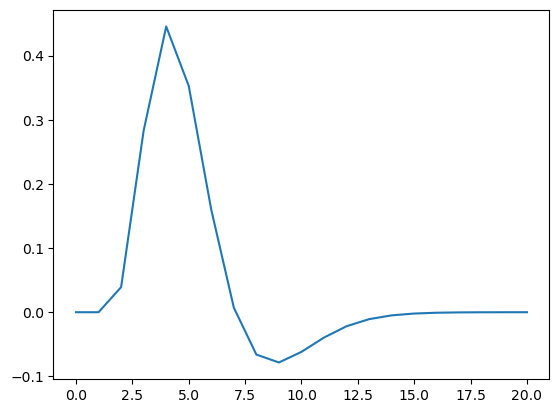

In [17]:
plt.plot(hrf)

In [18]:
impulse = np.zeros(120)
impulse[[20, 60, 100]] = 1
impulse_hrf = np.convolve(impulse, hrf)[: len(impulse)]

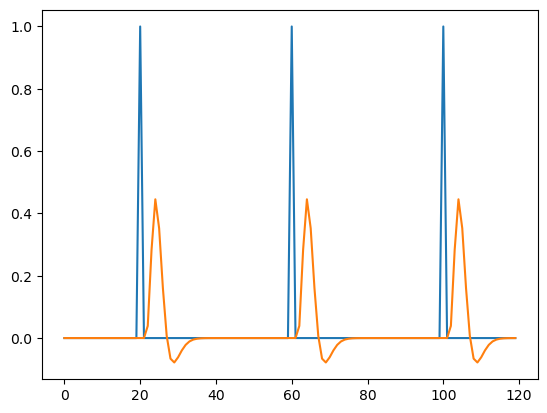

In [19]:
plt.plot(impulse)
plt.plot(impulse_hrf)

# Delayer

In [4]:
import numpy as np
from voxelwise_tutorials.delayer import Delayer

In [5]:
delayer = Delayer(delays=[2, 3, 4, 5])

In [6]:
data = np.arange(1, 11).reshape(-1, 1)

In [7]:
data

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [8]:
delayer.fit_transform(data)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [2, 1, 0, 0],
       [3, 2, 1, 0],
       [4, 3, 2, 1],
       [5, 4, 3, 2],
       [6, 5, 4, 3],
       [7, 6, 5, 4],
       [8, 7, 6, 5]])